In [52]:
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
import cv2
from PIL import Image

## Load data

In [53]:
network_dim = int(256/2)  # ensure that this is always greater than max node number that occurs in your data
                      # in addition it needs to fit to the unet layer for concatenation

In [54]:
#graphs
# #masks = glob.glob("../input/graph_images/train/label/*.png")
# masks = np.load('../input/graph_images/train/label/adjcouput_matrix.npy',allow_pickle='TRUE').item()
# orgs = glob.glob("../input/graph_images/train/image/*.png")
#training images
#masks = np.load('S:/06_Studienarbeit/03_CNN/generate_data/data/train/label/adjcouput_matrix.npy',allow_pickle='TRUE').item()
masks = glob.glob('S:/studenten/Rausch/06_Studienarbeit/03_CNN/generate_data/data/train_less128_2000imgs/label/*')
masks = masks[0:5]
orgs = glob.glob("S:/studenten/Rausch/06_Studienarbeit/03_CNN/generate_data/data/train_less128_2000imgs/image/*.png")
orgs = orgs[0:5]
#every training image has less than 128 nodes

In [56]:
#training images
imgs_list = []
masks_list = []
for image, mask in zip(orgs, masks):
    I = cv2.imread(image)
    key = image
    graph_label = np.load(masks[int(key[-14:-9])], allow_pickle=True)
    graph_label_norm = graph_label.copy()
    positions = graph_label[:, :2, 0]
    #normalize positions
    pos_norm = np.zeros(positions.shape)
    for i in range(len(positions)):
        pos_norm[i][0] = np.round((positions[i][0]/I.shape[1])*512, 0)
        pos_norm[i][1] = np.round((positions[i][1] /I.shape[0])*512, 0)
    graph_label_norm[:, :2, 0] = pos_norm
    #pad the label to obtain uniform array sizes
    #graph_label_padded = np.pad(graph_label_norm, ((0, network_dim-graph_label.shape[0]), (0, network_dim-graph_label.shape[1]), (-9.9, -9.9)))
    #graph_label_padded = np.pad(graph_label_norm, ((0, 0), (0, 0), (0, 0)))
    #graph_label_padded = graph_label_norm
    imgs_list.append(np.array(Image.open(image).convert('L').resize((512,512))))
    #print(graph_label_padded)
    #masks_list_position.append(np.array(graph_label_norm[:, 0:2, 0]))
    #masks_list_adjacency.append(np.array(graph_label_norm[:, 2:, 0]))
    masks_list.append(graph_label_norm)
imgs_np = np.asarray(imgs_list)

## Plot images + masks + overlay (mask over original)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


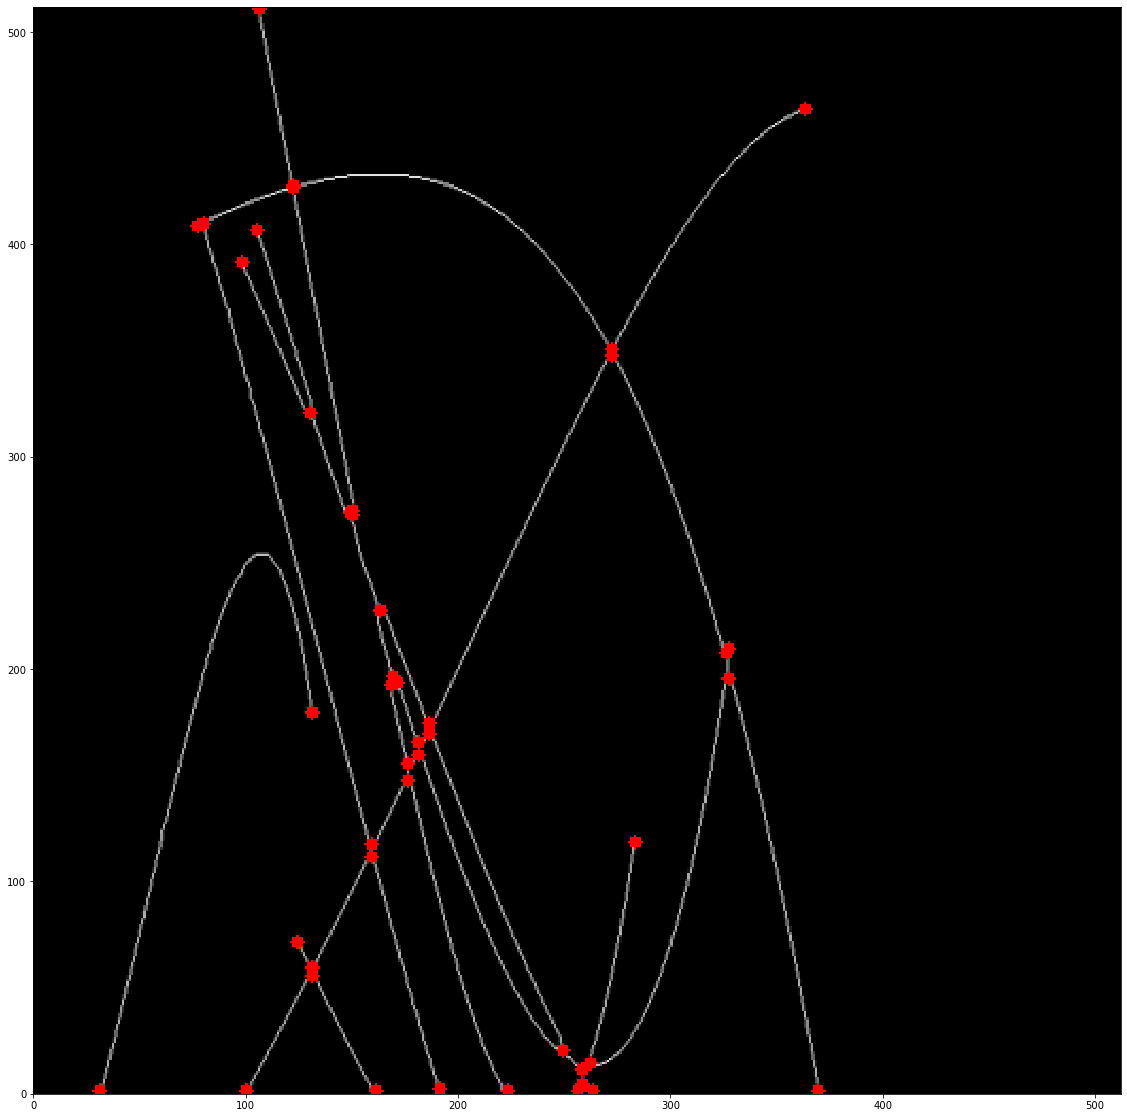

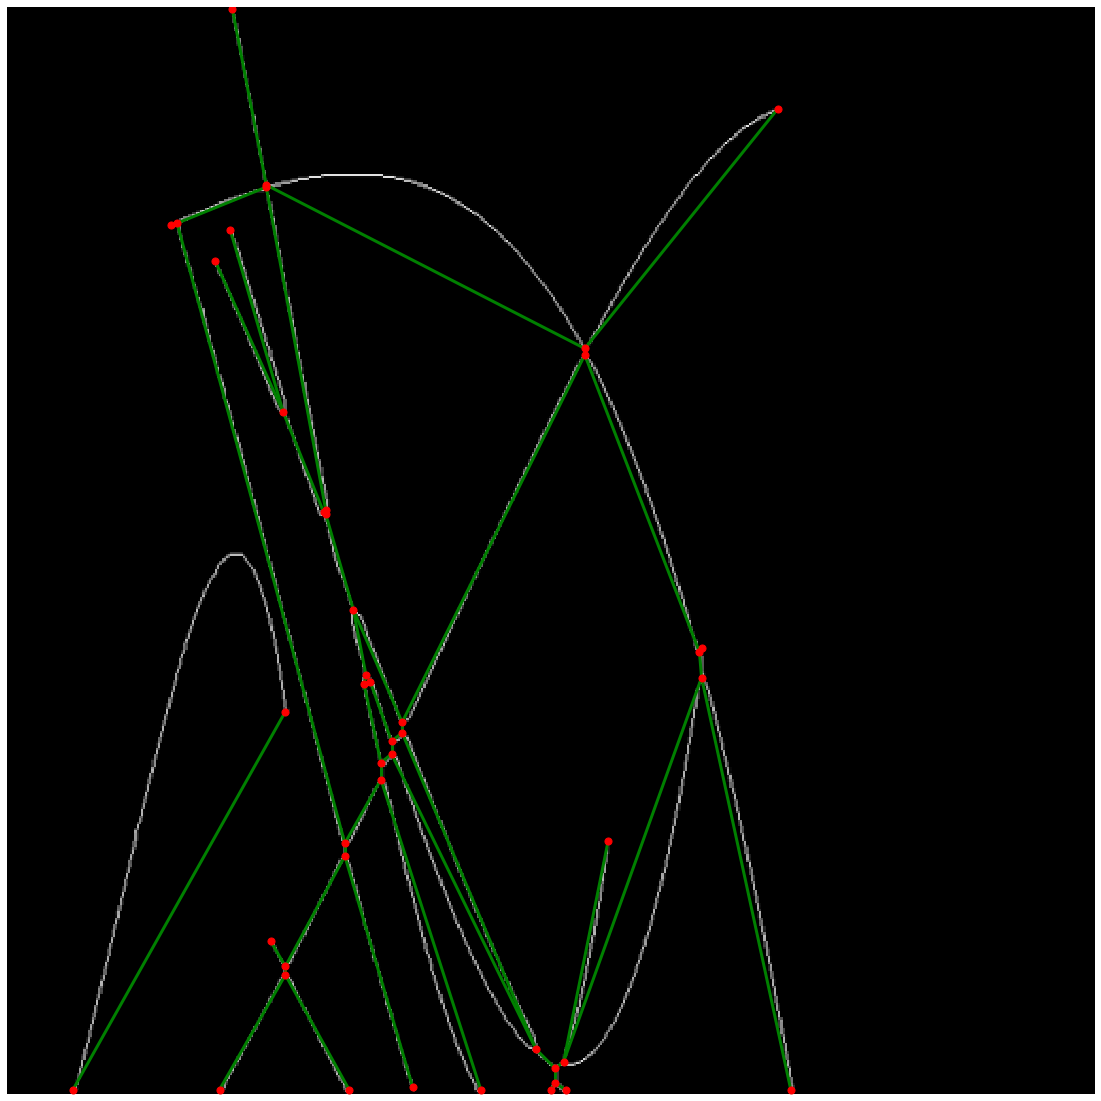

In [57]:
from keras_unet.utils_regine import plot_graph_on_img, plot_nodes_on_img
node_thick = 6
index = 3
save = True

masks_np = np.asarray(masks_list[index])
#uniform array sizes are necessary
y_positions_label = masks_np[:,0:2, 0]
y_adjacency_label = masks_np[:,2:, 0]
node_img = plot_nodes_on_img(imgs_np[index,:,:], y_positions_label, node_thick)
fig = plot_graph_on_img(imgs_np[index,:,:], y_positions_label, y_adjacency_label)

In [58]:
   # tailor the data to the specific pre defined network dimension
a = np.full((len(masks_list),network_dim *2), -9.9)
adj_flatten_dim = int((network_dim*network_dim-network_dim)/2)
b = np.zeros((len(masks_list),adj_flatten_dim))
for index in range(len(masks_list)):
    masks_np = np.asarray(masks_list[index])
    y_label_positions = masks_np[:,0:2, 0] # last zero --> without attributes
    y_label_adjacency = masks_np[:,2:, 0]  # last zero --> without attributes
    # form position matrix and adjacency in a one dimensional vector information
    y_label_positions = y_label_positions.reshape((y_label_positions.shape[0]*2))
    adjacency_label_indices = np.triu_indices(y_adjacency_label.shape[1], k = 1)
    y_label_adjacency = y_label_adjacency[adjacency_label_indices[0],adjacency_label_indices[1]]
    a[index,0:y_label_positions.shape[0]] = y_label_positions
    b[index,0:y_label_adjacency.shape[0]] = y_label_adjacency
y_label = [a, b]
print('total number of positions: ', y_label[0].shape)
print('total number of relevant adjacency etries: ', y_label[1].shape)

total number of positions:  (5, 256)
total number of relevant adjacency etries:  (5, 8128)


## Get data into correct shape, dtype and range (0.0-1.0)

In [60]:
print(imgs_np.max(), masks_np.max())
x = np.asarray(imgs_np, dtype=np.float32)/255
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)

241 968.8575961960642


##  Train/val split

In [62]:
from sklearn.model_selection import train_test_split
# split data
x_train, x_val, y_train_positions,y_val_positions, y_train_adjacency, y_val_adjacency = train_test_split(x, y_label[0], y_label[1], test_size=0.1, random_state=0)
from models_graph.prepare_functions import convert_to_tensor
# convert from numpy to tensorflow object
x_train = convert_to_tensor(x_train)
x_val = convert_to_tensor(x_val)
y_train_positions = convert_to_tensor(y_train_positions)
y_train_adjacency = convert_to_tensor(y_train_adjacency)
y_val_positions = convert_to_tensor(y_val_positions)
y_val_adjacency = convert_to_tensor(y_val_adjacency)

x_train:  (4, 512, 512, 1)
y_train_positions:  (4, 256)
 y_train_adjacency:  (4, 8128)
x_val:  (1, 512, 512, 1)
y_val_positions:  (1, 256)
y_val_adjacency:  (1, 8128)


## Initialize network

In [63]:
from models_graph.custom_graph_head import custom_graph_head, custom_adj_unet
print(x_train.shape)
input_shape = (512, 512, 1)
model = custom_adj_unet(input_size = input_shape, pretrained_weights =None, network_dim = network_dim)

(4, 512, 512, 1)


## Network shape

In [64]:
print('Input Shape: ',model.input_shape)
print('Output Shape: ',model.output_shape)
print('with position vector: ',model.output_shape[0], ' and adjacency vector: ', model.output_shape[1])
model.summary()

Input Shape:  (None, 512, 512, 1)
Output Shape:  [(None, 256), (None, 8128)]
with position vector:  (None, 256)  and adjacency vector:  (None, 8128)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_image[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 

In [65]:
import os
os.environ["PATH"] += os.pathsep + "C:\\Program Files\\Graphviz\\bin\\"
import sys
print(sys.path)
sys.path.append("C:\\Program Files\\Graphviz\\bin\\")

['C:\\Users\\Schüle\\git\\LearnGraphExtraction\\keras-unet\\notebooks', 'C:\\Users\\Schüle\\git\\LearnGraphExtraction', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\Lib', 'c:\\users\\schüle\\appdata\\local\\programs\\python\\python37\\python37.zip', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\DLLs', 'c:\\users\\schüle\\appdata\\local\\programs\\python\\python37', '', 'C:\\Users\\Schüle\\AppData\\Roaming\\Python\\Python37\\site-packages', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\deepwalk-1.0.3-py3.7.egg', 'c:\\users\\schüle\\git\\labelme', 'c:\\users\\schüle\\git\\learngraphextraction\\keras-unet', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\win32', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Schüle\\AppData\\Local\\Pro

In [66]:
import tensorflow.python.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint
model_filename = 'graph_extract_model_v0.h5'
callback_checkpoint = ModelCheckpoint(model_filename)

## Compile + train

In [68]:
#import keras as keras
import tensorflow as tf
import tensorflow.python.keras as keras
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.optimizer_v2.gradient_descent import SGD
#from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from models_graph.losses import loss_node_positions
from models_graph.losses import loss_adjacency

In [69]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

model.compile(
   optimizer=tf.keras.optimizers.RMSprop(1e-3),
   loss={
       "pixel_position_of_nodes": keras.losses.MeanSquaredError(),
       "adjacency_matrix":   keras.losses.BinaryCrossentropy(),
   },
   loss_weights=[0.8, 1.0],
)
#print('done')
model.output

[<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'pixel_position_of_nodes')>,
 <KerasTensor: shape=(None, 8128) dtype=float32 (created by layer 'adjacency_matrix')>]

In [70]:
from models_graph.losses import loss_node_positions
from models_graph.losses import loss_adjacency
print("x_train: ", x_train.shape)
print("y_train_positions: ", y_train_positions.shape)
print(" y_train_adjacency: ", y_train_adjacency.shape)
print("x_val: ", x_val.shape)
print("y_val_positions: ", y_val_positions.shape)
print("y_val_adjacency: ", y_val_adjacency.shape)

# model.fit({'input_image': x_train},{'pixel_position_of_nodes': y_train_positions, 'adjacency_matrix': y_train_adjacency},
#           epochs = 1, batch_size=2 ,
#           validation_data=({'input_image': x_val},{'pixel_position_of_nodes': y_val_positions, 'adjacency_matrix': y_val_adjacency}),
#         )

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train, [y_train_positions, y_train_adjacency],
          epochs = 10, batch_size=4 ,
          validation_data=(x_val,{'pixel_position_of_nodes': y_val_positions, 'adjacency_matrix': y_val_adjacency}),
          callbacks=[tensorboard_callback],)

(4, 8128)
(4, 256)
(1, 256)
(1, 8128)
Epoch 1/10
4/4 [==============================] - 22s 5s/step - loss: 276189.6344 - pixel_position_of_nodes_loss: 345228.5359 - adjacency_matrix_loss: 6.8010 - val_loss: 17140.2812 - val_pixel_position_of_nodes_loss: 21416.9004 - val_adjacency_matrix_loss: 6.7601
Epoch 2/10
4/4 [==============================] - 29s 8s/step - loss: 28718.8492 - pixel_position_of_nodes_loss: 35890.7824 - adjacency_matrix_loss: 6.2233 - val_loss: 29747.0137 - val_pixel_position_of_nodes_loss: 37182.0820 - val_adjacency_

In [71]:
# Save the entire model to a HDF5 file
model.save(model_filename)



## Plot original + ground truth + pred + overlay (pred on top of original)

In [73]:
#compute prediction
#model.load_weights(model_filename)
#first three elements in validation set
print(x_val.shape)
x_val012 = x_val[:3, :, :, :]
y_pred = model.predict(x_val012)
predicted_adjacency_matrices = y_pred[1]
predicted_positions = y_pred[0]

predicted_adjacency0 = predicted_adjacency_matrices[0, :]
# predicted_adjacency1 = predicted_adjacency_matrices[1, :]
# predicted_adjacency2 = predicted_adjacency_matrices[2, :]

predicted_positions0 = predicted_positions[0, :]
# predicted_positions1 = predicted_positions[1, :]
# predicted_positions2 = predicted_positions[2, :]

(1, 512, 512, 1)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [75]:
#reshape
from keras_unet.utils_regine import plot_graph_on_img, plot_nodes_on_img
from models_graph.prepare_functions import create_adj_matrix, create_position_matrix

adj_matrix0 = create_adj_matrix(predicted_adjacency0,17)
position_matrix0 = create_position_matrix(predicted_positions0,17)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


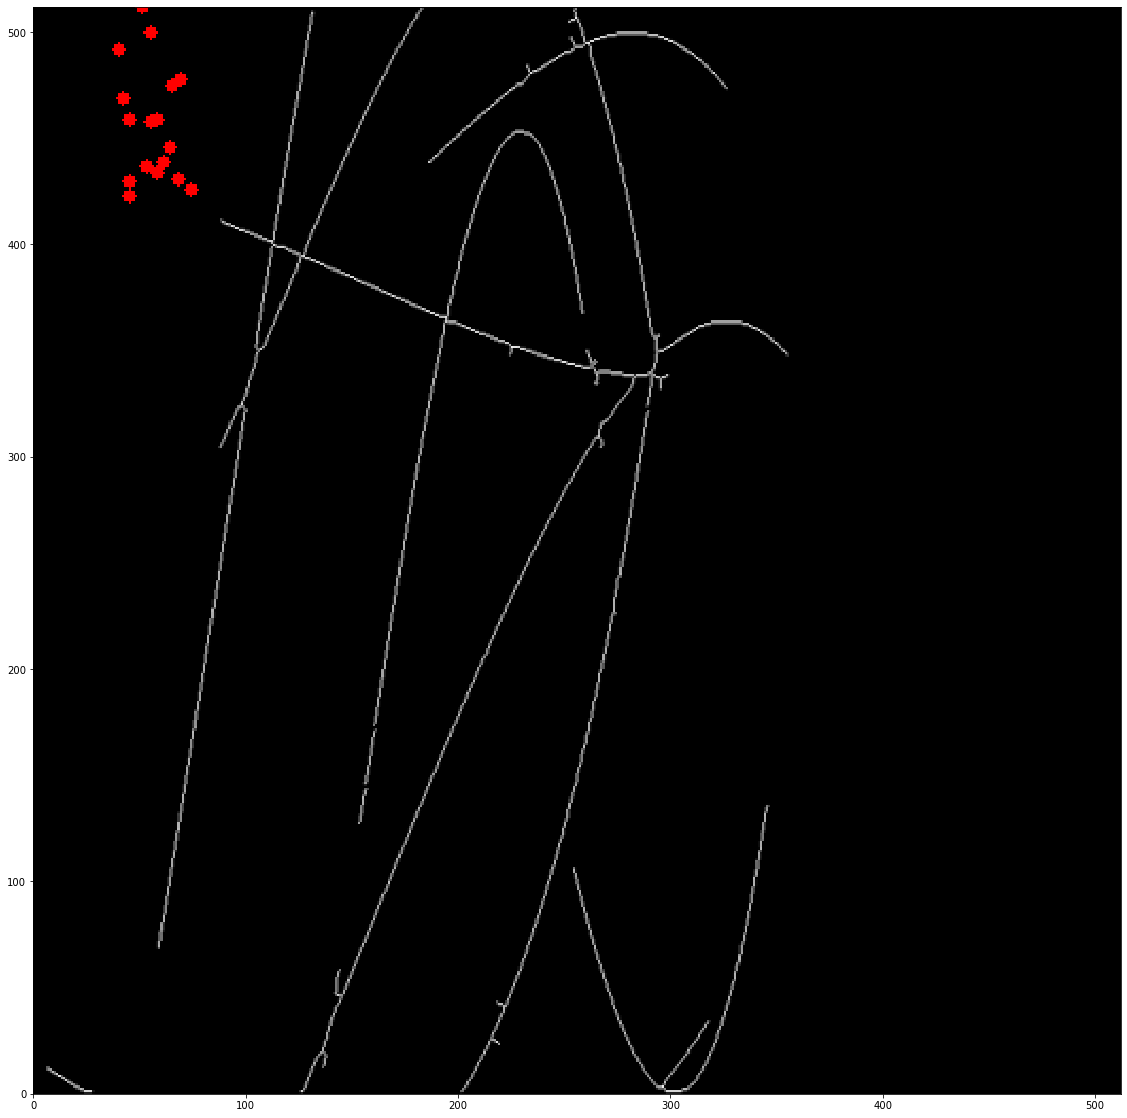

In [76]:
from keras_unet.utils_regine import plot_graph_on_img, plot_nodes_on_img
#plot nodes on img
node_thick = 6
index = 0
node_img = plot_nodes_on_img(x_val.numpy()[index, :, :, 0], position_matrix0, node_thick)
#plot graph on img
# index = 0
# fig = plot_graph_on_img(x_val.numpy[index, :, :, 0], position_matrix0, adj_matrix0)

NameError: name 'y_val' is not defined